# Plot generation
### Plots for the LSTM_HC with my classsifiers

In [2]:
from scorers import scorer
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_output_into_dataframe

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [3]:
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

In [4]:
outcomes = {}

for dset in dsets:
    with open(f"./data/lstm_hc/list_result_{dset}.pkl", "rb") as f:
        outcomes[dset] = pickle.load(f)
        print(len(outcomes[dset]))

151
151
151


In [5]:
# iterate over the lists, convert them to dataframes
outcome_dfs = {}
for name, dset in outcomes.items():
    
    scoring = GuacamolMGenFailScorer(mgenfail_data_prefix='./data/mgenfail_assays',
                                     fingerprints_used='ECFP_2_1024',
                                     name=name)

    outcome_dfs[name] = process_output_into_dataframe(dset, scoring)
    
    # save the resulting dataframe to csv
    outcome_dfs[name].to_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
    # basic sanity check
    print(len(outcome_dfs[name]))

# keep the memory clean
del(outcomes)

9it [00:05,  1.54it/s]


KeyboardInterrupt: 

In [4]:
# use this block to skip preprocessing

outcome_dfs = {}

for name in dsets:
    outcome_dfs[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")

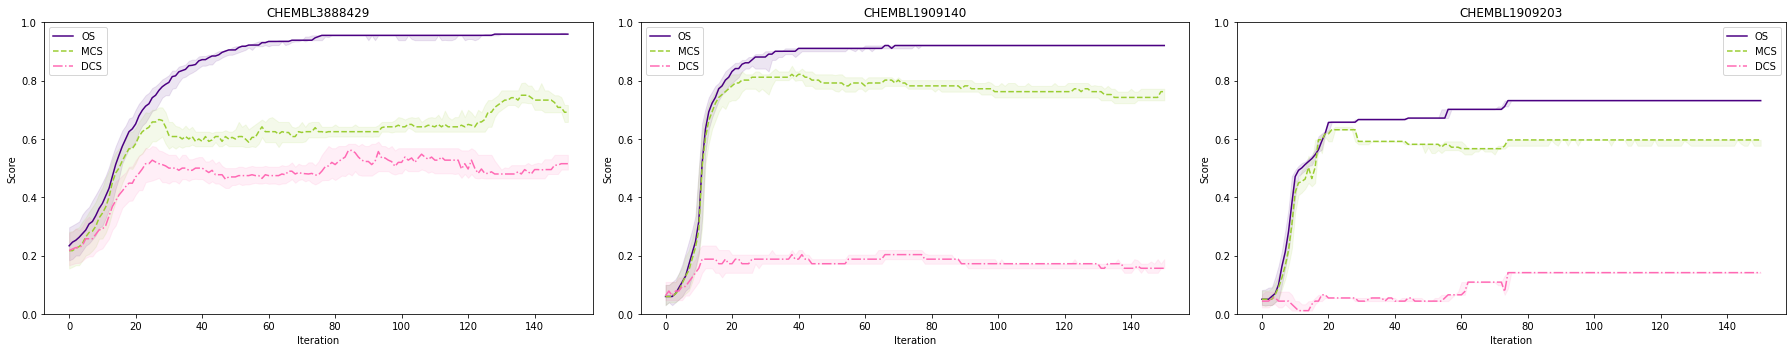

In [5]:
# make a plot
fig, axs = plt.subplots(1,3,figsize=(25,5))

for (name, data), (i, ax) in zip(outcome_dfs.items(), enumerate(axs)):
    plot_medians(data, 
                 ax,
                 (0, i),
                 name,
                 'Score',
                 'Iteration',
                 y_scale = (0.,1.),
                 x_scale = None
                )
plt.tight_layout()

### Similar line plots for the outcomes of the PGFS model.

In [2]:
from scorers import scorer
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_PGFS_output_into_dataset

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [3]:
run_dirs = {'./data/run_B_long': 'CHEMBL3888429', 
            './data/run_A_long': 'CHEMBL1909140', 
            './data/run_C_long': 'CHEMBL1909203'}

In [4]:
outcomes = {}

for location, name in run_dirs.items():
    # load the pickle
    with open(f"{location}/smiles_collected.pkl", "rb") as f:
        outcomes[name] = pickle.load(f)
        print(len(outcomes[name]))
    
    # fire up the scorer
    scoring = GuacamolMGenFailScorer(mgenfail_data_prefix='./data/mgenfail_assays',
                                 fingerprints_used='ECFP_2_1024',
                                 name=name)

    # convert into dataframe
    outcomes[name] = process_PGFS_output_into_dataset(outcomes[name], scoring)
        
    # save the dataframe as csv for future use
    outcomes[name].to_csv(f"{location}/smiles_collected.csv")
    
    print(len(outcomes[name]))

  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/22 [00:00<?, ?it/s]

108000
22


  0%|          | 0/22 [00:00<?, ?it/s]

118800
22


100%|██████████| 22/22 [02:09<00:00,  5.89s/it]


118800


In [5]:
# use this block to skip preprocessing

outcomes = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    outcomes[name] = df

    

108000
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5


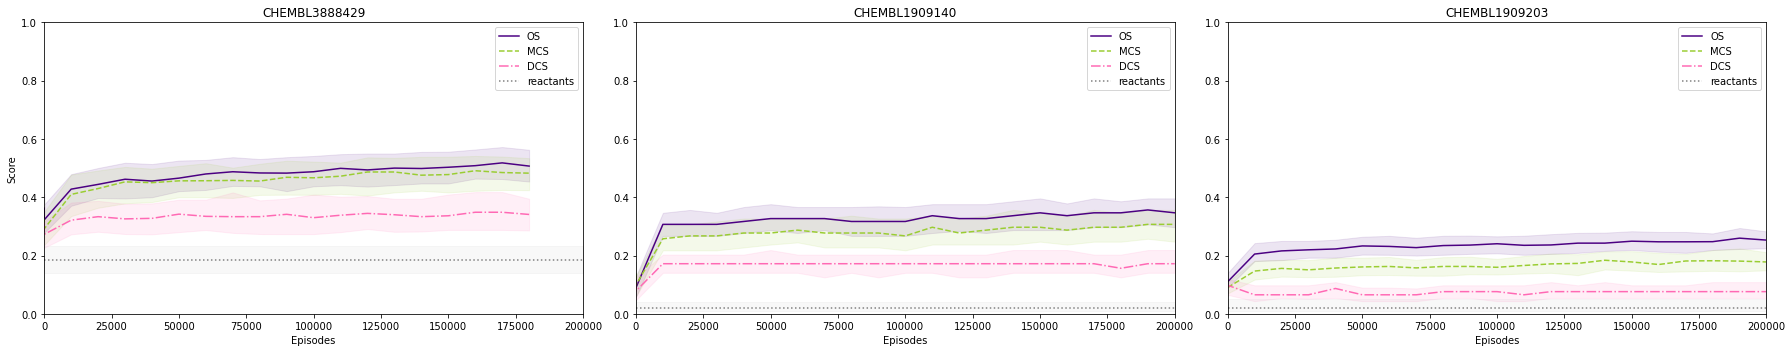

In [7]:
# make a plot
fig, axs = plt.subplots(1,3,figsize=(25,5))

for (name, data), (i, ax) in zip(outcomes.items(), enumerate(axs)):
    plot_medians(data, 
                 ax,
                 (0, i),
                 name,
                 'Score',
                 'Episodes',
                 y_scale = (0.,1.),
                 x_scale = (0.,  200000.)
                )
    
    # load the scorer once more
    scoring = GuacamolMGenFailScorer(mgenfail_data_prefix='./data/mgenfail_assays',
                             fingerprints_used='ECFP_2_1024',
                             name=name)
    # load the reactants set
    with open('./data/run_A/preprocessed/reactants_processed.pkl', 'rb') as f:
        reactants = pickle.load(f)
    raw_scores = scoring.raw_score_list(reactants['smiles'].tolist())
    scores = np.array(raw_scores)
    quants = np.quantile(scores, [0.25, 0.5, 0.75])
    x_ticks = ax.get_xticks()
    bot = [quants[0] for _ in x_ticks]
    med = [quants[1] for _ in x_ticks]
    top = [quants[2] for _ in x_ticks]
    # plot the median an quantiles of the reactant set
    ax.plot(x_ticks, med, ':', color='grey', label='reactants')
    ax.fill_between(x_ticks, bot, top, alpha=0.1, color='silver')    
    ax.legend()
    
plt.tight_layout()

In [ ]:
with open('./data/run_A/preprocessed/reactants_processed.pkl', 'rb') as f:
    reactants = pickle.load(f)
reactants

In [ ]:
smi = reactants['smiles'].iloc[0:20]
smi

In [ ]:
smi_a = smi.sample(n=10)
smi_b = smi[~smi.isin(smi_a)]

In [ ]:
smi_a


### Consider the diversity of the outputs

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from matplotlib import pyplot as plt

from gym_PGFS.chemwrapped import ChemMolFromSmilesWrapper, ECFP6_bitvector_numpy

In [2]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [3]:
run_dirs = {'./data/run_B_long': 'CHEMBL3888429', 
            './data/run_A_long': 'CHEMBL1909140', 
            './data/run_C_long': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

outcome_dfs = {}

for name in dsets:
    outcome_dfs[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")

In [4]:
def compute_tanimoto_similarity_matrix(mol_list):
    similarity_matrix = np.zeros((len(mol_list), len(mol_list)))
    # print(similarity_matrix.shape)
    mol_list = [AllChem.GetMorganFingerprintAsBitVect(ChemMolFromSmilesWrapper(mol), 2, nBits=1024) for mol in mol_list]
    for i in range(len(mol_list)):
        for j in range(i+1, len(mol_list)):
            similarity_matrix[i, j] = DataStructs.FingerprintSimilarity(mol_list[i],mol_list[j], metric=DataStructs.TanimotoSimilarity)
    return similarity_matrix

In [5]:
def tanimoto_similarity_score(mat):
    mat = mat - np.identity(len(mat))
    # adjusted by the total number of comparisons made, therfore has the range of 0 to 1
    return np.linalg.norm(mat, 2)/(len(mat)*(len(mat)-1)/2)

In [6]:
def in_group_similarity_scores_plot(df):
    retlist = []
    print(f"Available values: {df['epoch'].unique().tolist()}")
    for i in df['epoch'].unique().tolist():
        # for each epoch output compute the score
        lst = df[(df['epoch']==i)&(df['type']=='OS_MODE')].smiles.tolist()
        mat = compute_tanimoto_similarity_matrix(lst)
        val = tanimoto_similarity_score(mat)
        print(i, len(mat), val)
        retlist.append(val)
    return retlist

In [7]:
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df

    

108000
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5


In [9]:
# compute the lines for both algorithms
lstm_lines = {}
pgfs_lines = {}

for dset in dsets:
    # compute the lstm line for the dataset
    lstm_lines[dset] = in_group_similarity_scores_plot(outcome_dfs[dset])
    pgfs_lines[dset] = in_group_similarity_scores_plot(pgfs_out[dset])

Available values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
0 990 0.0001607484861702231
1 972 0.00015751873521965983
2 942 0.00016045306694722743
3 871 0.00017570889893499202
4 847 0.00018135787304896008
5 887 0.00017993604701166868
6 888 0.00018165171213346706
7 895 0.00018592912945873224
8 906 0.00018801804193275417
9 911 0.00019751415742982258
10 918 0.00020071110003481554
11 922 0.00021225

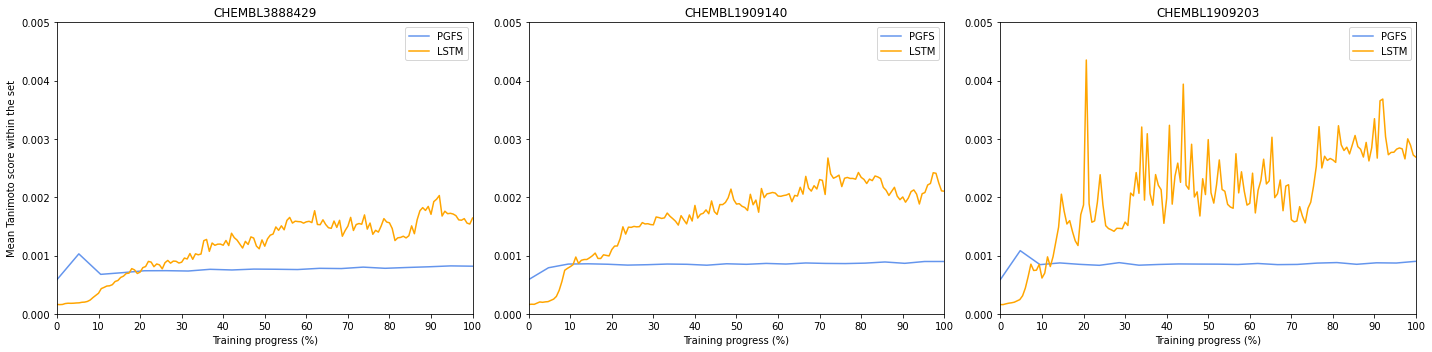

In [25]:
# now plot the lines
fig, axs = plt.subplots(1,3,figsize=(20,5))

for i, (dset, ax) in enumerate(zip(dsets, axs)):
    # prepare and plot the pgfs data
    pgfs_lst = pgfs_lines[dset]
    pgfs_x = np.linspace(0., 100., num=len(pgfs_lst))
    ax.plot(pgfs_x, pgfs_lst, color='cornflowerblue', label='PGFS')

    # prepare and plot the pgfs data
    lstm_lst = lstm_lines[dset]
    lstm_x = np.linspace(0., 100., num=len(lstm_lst))
    ax.plot(lstm_x, lstm_lst, color='orange', label='LSTM')
    
#     ax.set_yscale('log')
    ax.set_ylim((0., 0.005))
    ax.set_xlim((0.,100.))
    
    ax.set_xticks(np.linspace(0., 100., num=11))
    ax.set_xlabel("Training progress (%)")
    ax.set_title(dset)
    
    if i == 0:
        ax.set_ylabel("Mean Tanimoto score within the set")
    
    ax.legend()
plt.tight_layout()
plt.show()

## Estimate the number of molecules accessible to the PGFS

In [63]:
from gym_PGFS.envs.PGFS_trials import gym_PGFS_basic_from_config
from gym_PGFS.valuation.comparison_vs_random import record_smiles_from_env
from gym_PGFS.config import load_config

In [64]:
# the environment configurations are roughly similar
config = "./gym_PGFS/configs/mgenfail_config_new_A.yaml"
root_dir = './data/run_A_new/'
conf = load_config(config)  # "./gym_PGFS/configs/config_server_default.yaml"
env = gym_PGFS_basic_from_config(root_dir, conf)  # './data'

Templates loaded from templates_processed.pkl
Reactions loaded from reactions_processed.pkl
Reactants loaded from reactants_processed.pkl
Loaded checkpoint.
ChemWorld <gym_PGFS.chemutils.ChemWorld object at 0x7f1de36a7340> has been deployed.
0           C#CCCI
1      O=C(O)C#CBr
2        C#CC(N)CO
3          CC#CCCO
4        C#CC(N)CC
          ...     
123       NCC(O)CO
124       NC(CO)CO
125    CC(N)C(N)=O
126      CC(O)=CCN
127      NC1CNC1=O
Name: smiles, Length: 128, dtype: object


In [65]:
set_of_smiles = {}
set_lengths = []

In [ ]:
for i in range(20):
    smis, errs = record_smiles_from_env(env, n_samples=100)
    smiles_last_step = [smi[-1] for smi in smis]
    set_of_smiles.update(smiles_last_step)
    newlen = len(set_of_smiles)
    print(i, newlen)
    set_lengths.append(newlen)

## Compare the dcs of the last step of LSTM_HC and PGFS models

In [1]:
import os
os.chdir('../')
os.getcwd()

'/home/boto/chemPGFS/gymPGFS'

In [2]:
from scorers import scorer
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
from gym_PGFS.valuation.plot_utils import plot_medians, process_PGFS_output_into_dataset

In [6]:
run_dirs = {'./data/run_B_long': 'CHEMBL3888429', 
            './data/run_A_long': 'CHEMBL1909140', 
            './data/run_C_long': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df

    

108000
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5


In [7]:
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    # now make a boxplot
    lstms[dataset_name] = lstm.value.to_numpy()
    pgfss[dataset_name] = pgfs.value.to_numpy()
    


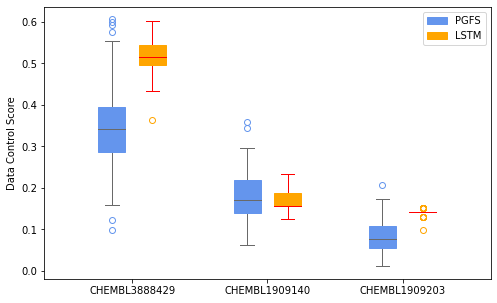

In [8]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
plt.ylabel(f"Data Control Score")
# plt.xlabel("")

rng = np.arange(len(pgfs_out.keys()))
c, c_highlight = 'cornflowerblue', 'dimgrey'
pgfs_boxes = ax.boxplot(pgfss.values(), patch_artist=True, positions=rng-0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))
c, c_highlight = 'orange', 'red'
lstm_boxes = ax.boxplot(lstms.values(), patch_artist=True, positions=rng+0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))

ax.legend([pgfs_boxes["boxes"][0], lstm_boxes["boxes"][0]],
          ['PGFS', 'LSTM'],
          loc='upper right')

plt.xticks(rng, pgfss.keys())
plt.show()